In [12]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
%autoreload 2

In [14]:
import os
import sys
import random
import glob
import pickle
import itertools
import io
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas
import time
from tqdm import tqdm

import sklearn

import tensorflow as tf
import tf_data


In [4]:
import tensorflow as tf
import json, os
import numpy as np

# Tested with TensorFlow 2.1.0
print('version={}, CUDA={}, GPU={}, TPU={}'.format(
    tf.__version__, tf.test.is_built_with_cuda(),
    # GPU attached?
    len(tf.config.list_physical_devices('GPU')) > 0,
    # TPU accessible? (only works on Colab)
    'COLAB_TPU_ADDR' in os.environ))

if len(tf.config.list_physical_devices('GPU')) > 0:
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
    strategy = tf.distribute.OneDeviceStrategy("gpu:0")

version=2.3.0, CUDA=True, GPU=True, TPU=False


# Dataset building

In [3]:
data_path = {"ele_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v2/training/calo_matched/*.proto",
             #"gamma_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/training/calo_matched/*.proto",
             #"ele_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v2/training/no_calo_matched/*.proto",
             #"gamma_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/training/no_calo_matched/*.proto"
            }

In [4]:
features = [ "en_cluster","et_cluster", 
            "cluster_ieta","cluster_iphi","cluster_iz",
            "cluster_deta", "cluster_dphi",
            "cl_swissCross", "cl_nxtals", "cl_etaWidth","cl_phiWidth"]

In [5]:
_load_n_items = 10
_batch_size = 6
_nepochs = 1
_ntrain = 10000
_nval = 1000

In [6]:
# Load a balanced dataset from the list of paths given to the function. Selected only the requestes features from clusters and prepare batches
total_ds = tf_data.load_balanced_dataset_batch(data_path, features, _batch_size)
# the indexes for energy and et are from the features list we requestes
total_ds = tf_data.delta_energy_seed(total_ds, en_index=0, et_index=1)
total_ds = tf_data.training_format(total_ds) 

In [7]:
X,y = tf_data.get(total_ds)

In [ ]:
y_class, y_metadata = y

In [10]:
cl_X,cl_hits, is_seed,n_cl = X

# Graph building layer

In [60]:
from model import *
from plotting import * 

In [108]:
graph = GraphBuilding(output_dim_nodes=32)

In [109]:
cl_x, coord, adj, mask = graph(X[0],X[1])

In [110]:
mask

<tf.Tensor: shape=(6, 9), dtype=float32, numpy=
array([[1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0.]], dtype=float32)>

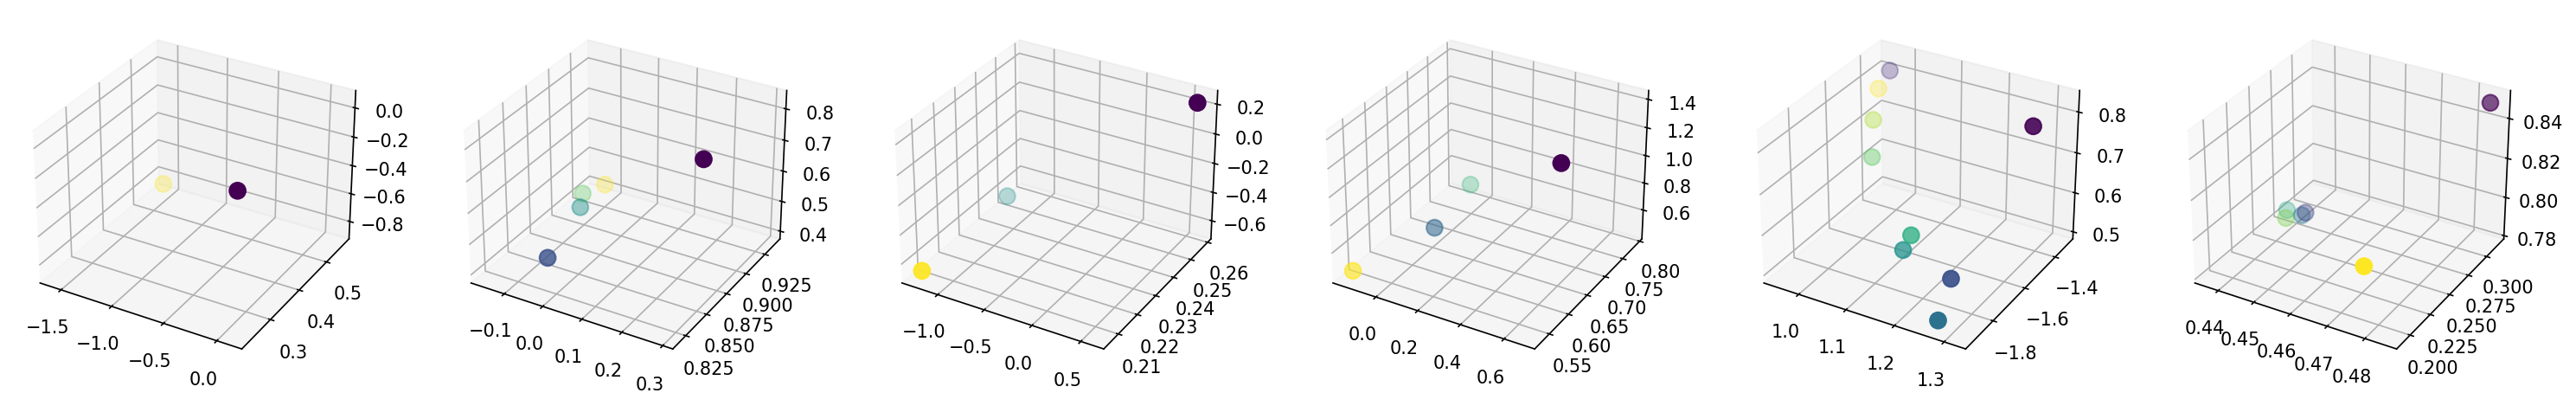

In [111]:
plot3D(coord, mask)

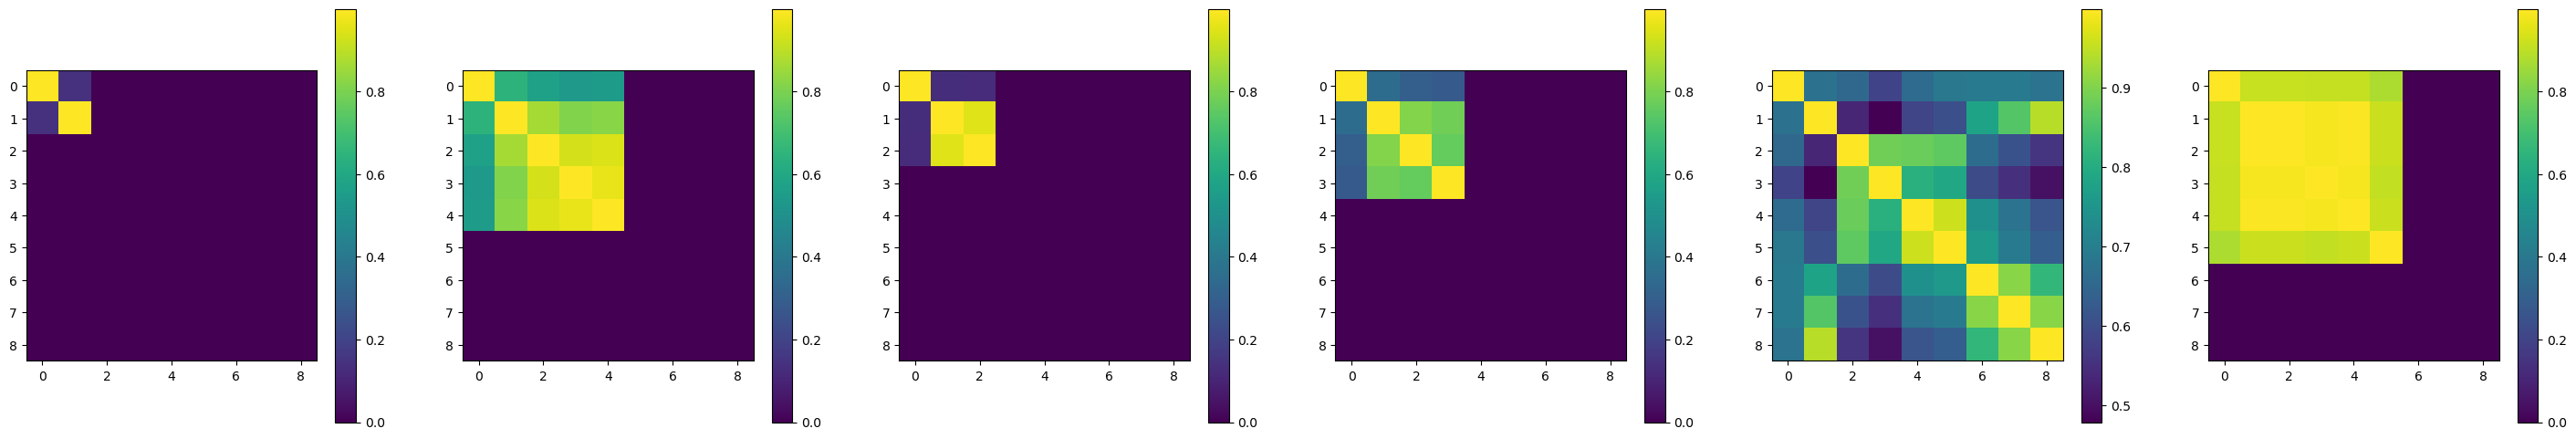

In [112]:
plotM(*adj)

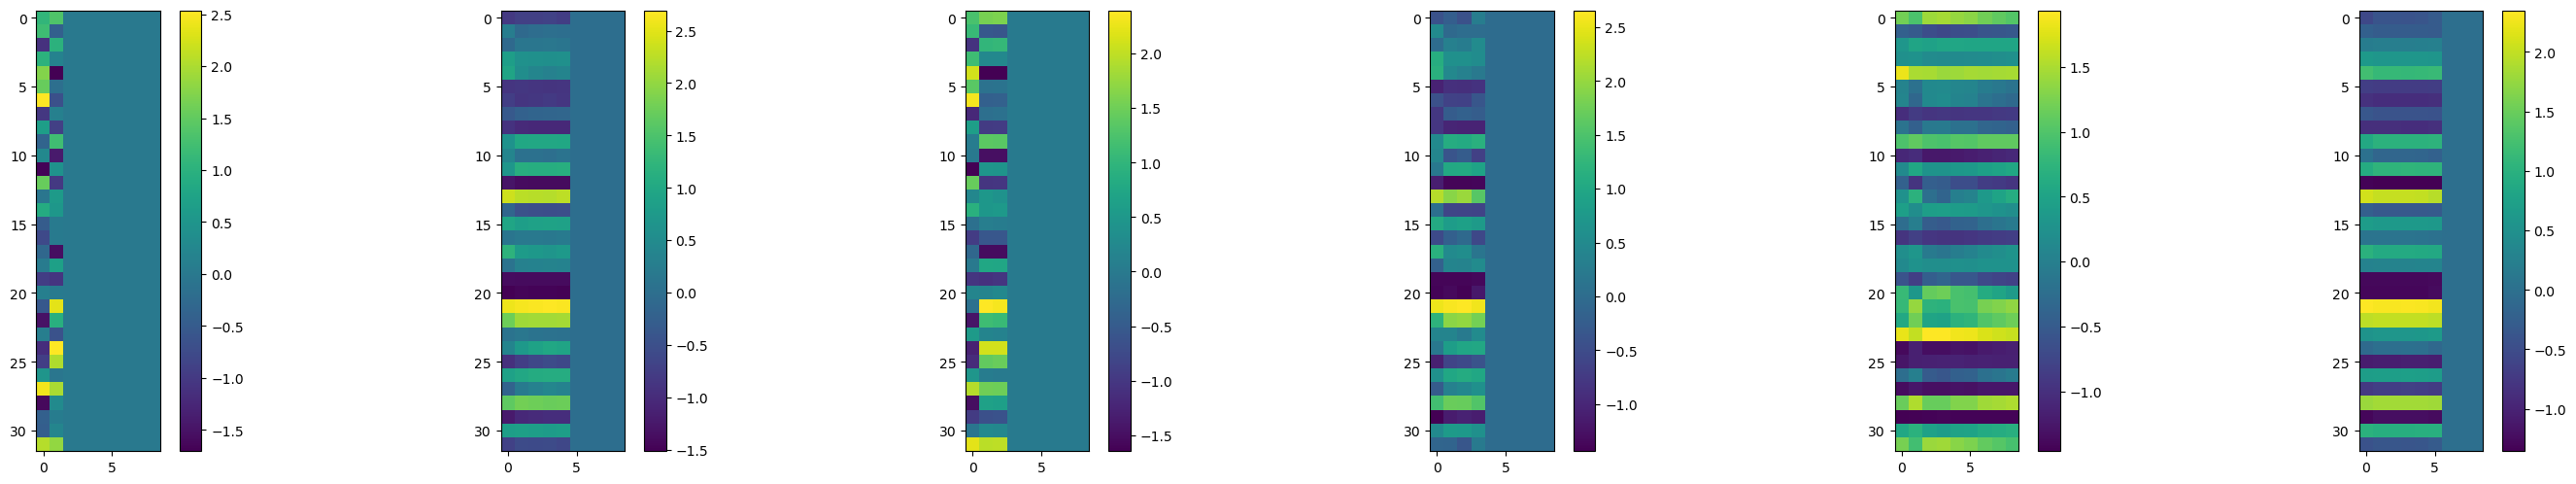

In [113]:
plotM(*cl_x)

# Complete model

In [3]:
from model import *
from plotting import * 

In [11]:
# output_dim_nodes == latent spoace dimension for the clusters
dcgn = DeepClusterGN(nconv=3, output_dim_nodes=32, layers_input=[64,64,64], layers_coord=[64,64,64,64])

In [19]:
dense_clclass, mask_cls, (cl_X, coord, adj ,out_gcn, out_SA, att_weights) = model(X)

ValueError: too many values to unpack (expected 6)

In [110]:
X, y = tf_data.get(ds_train)

In [17]:
X,y = tf_data.get(ds_test)

In [18]:
dense_clclass, mask_cls, (cl_X, coord, adj, output_rechits, out_gcn, concat_GCN_SA,att_weights) = model(X)

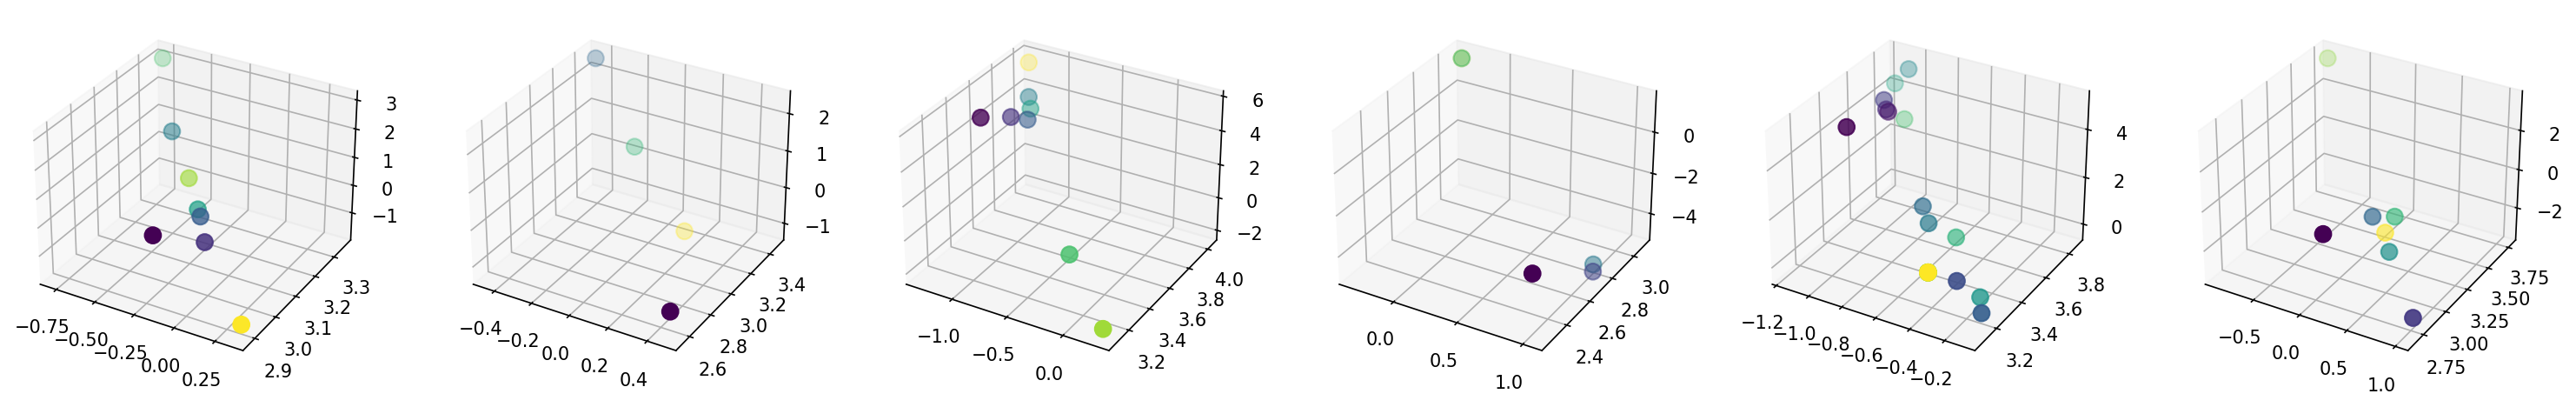

In [50]:
plot3D(coord[6:12], mask_cls)

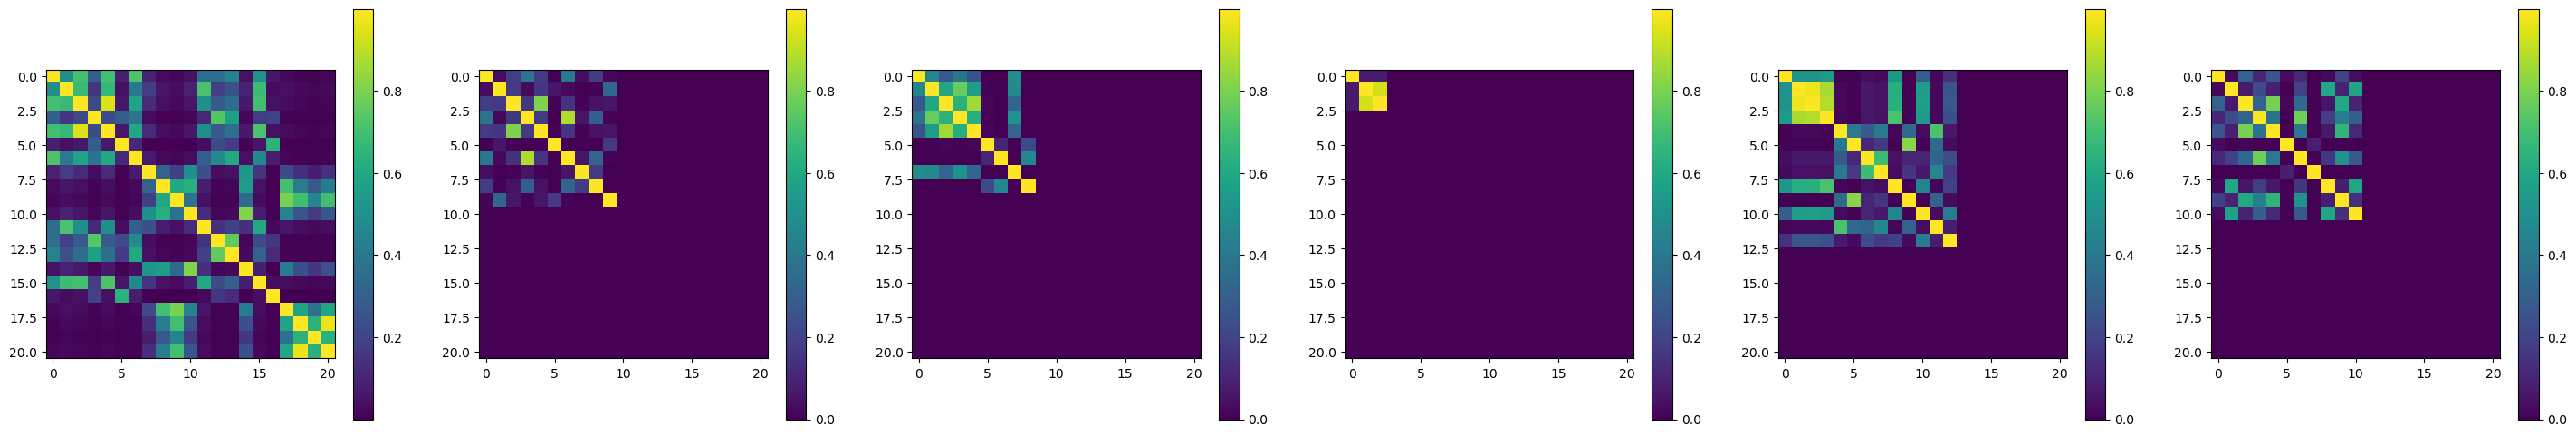

In [52]:
plotM(*adj[6:12])

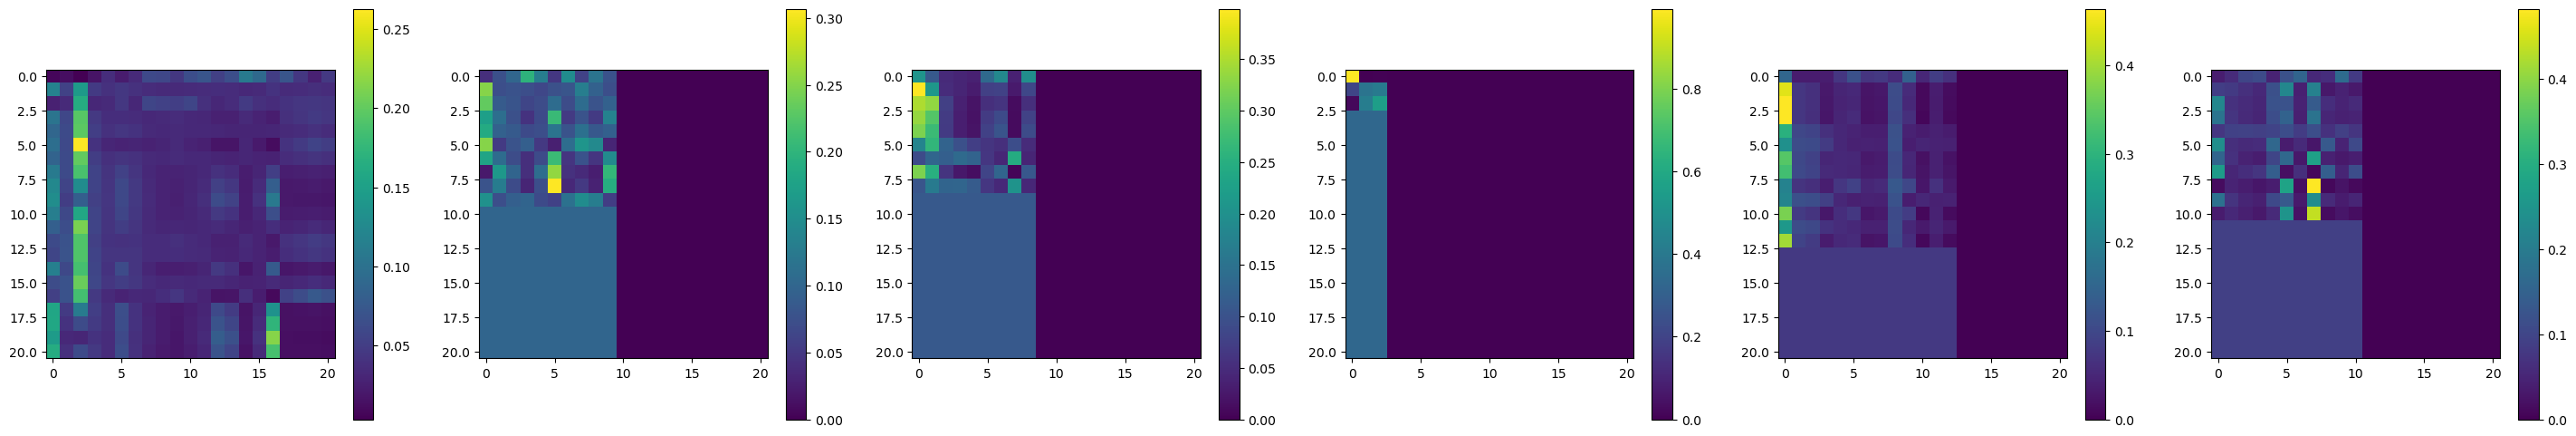

In [53]:
plotM(*att_weights[6:12], t=False)

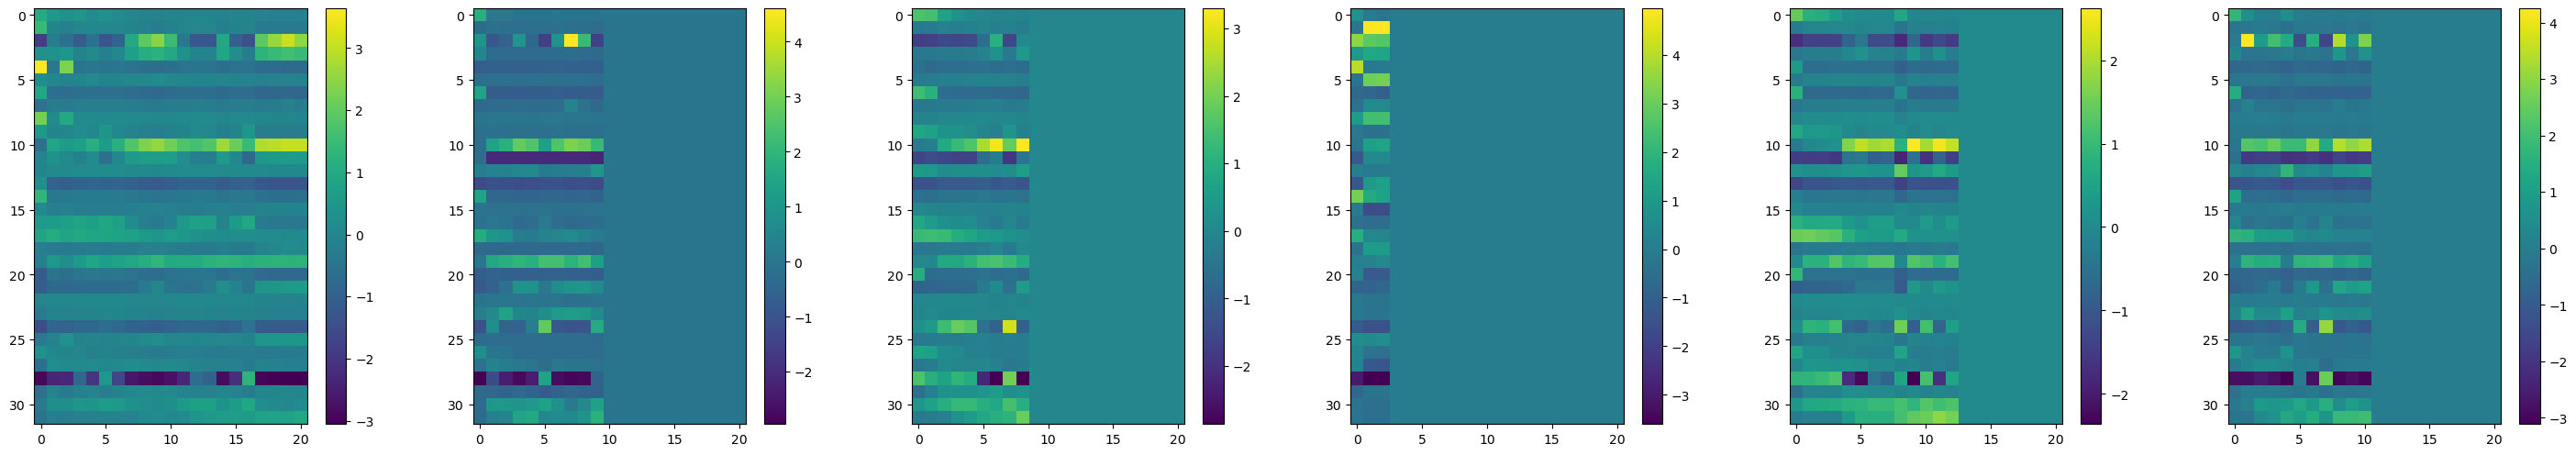

In [54]:
plotM(*cl_X[6:12])

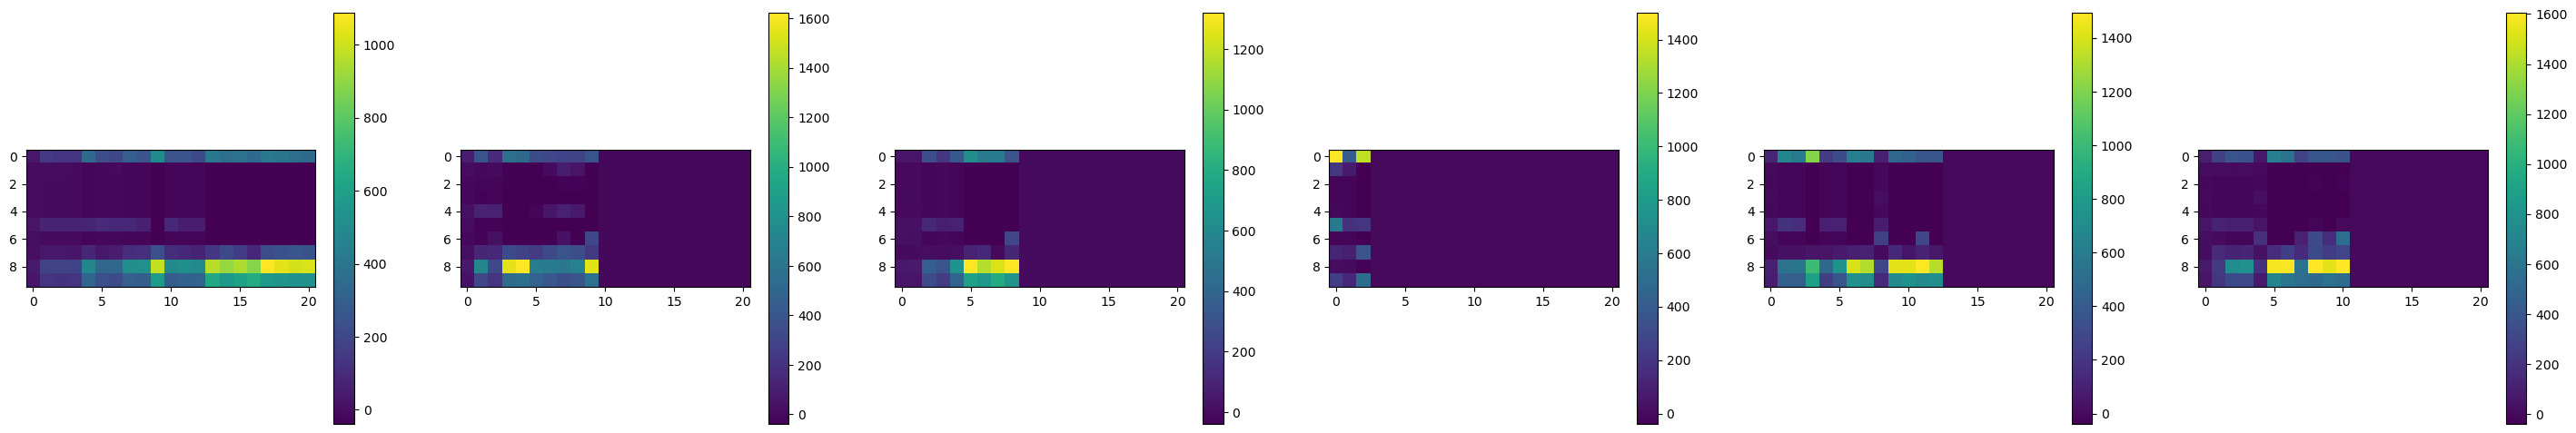

In [55]:
plotM(*output_rechits[6:12])

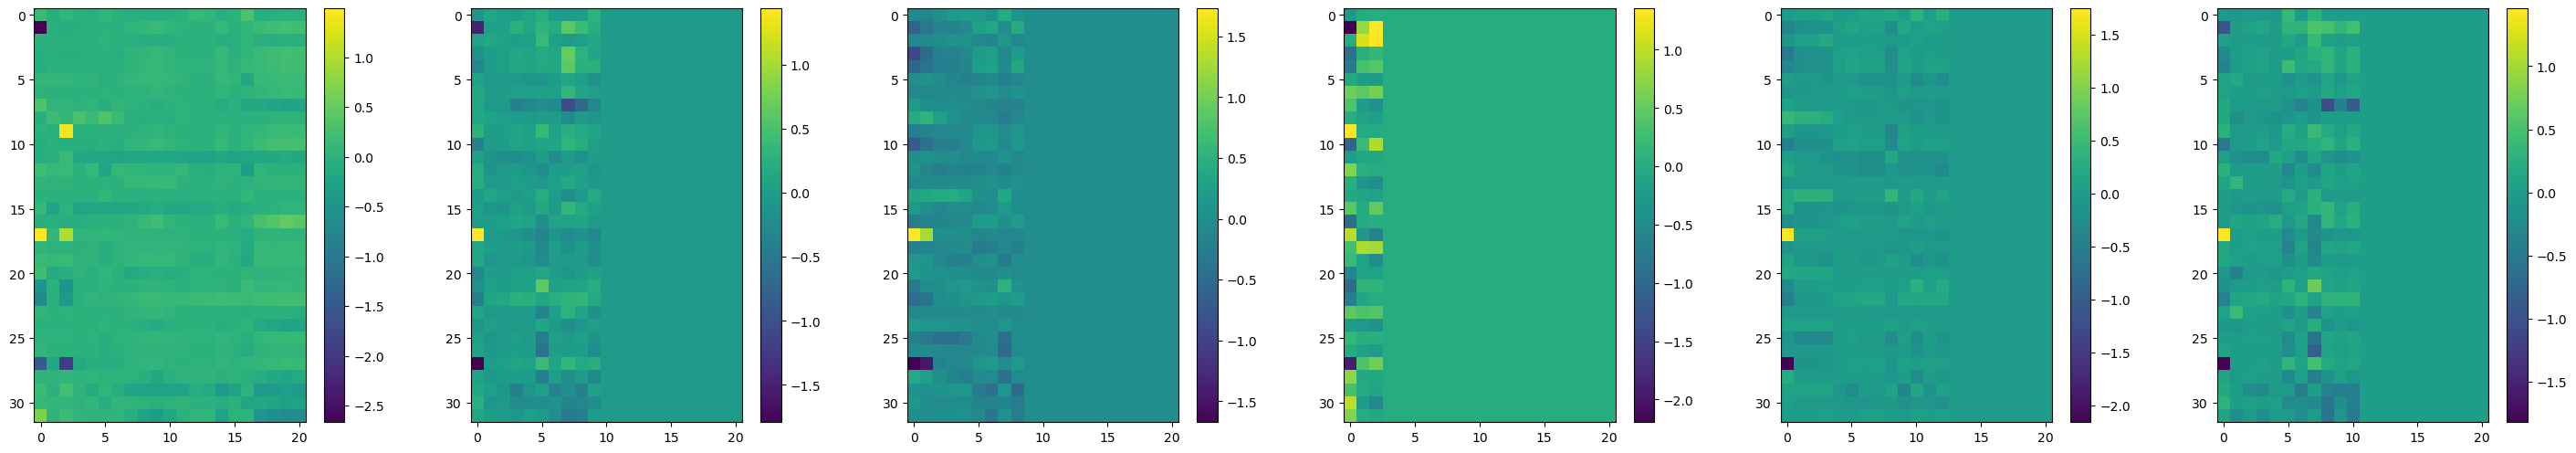

In [56]:
plotM(*out_gcn[6:12])

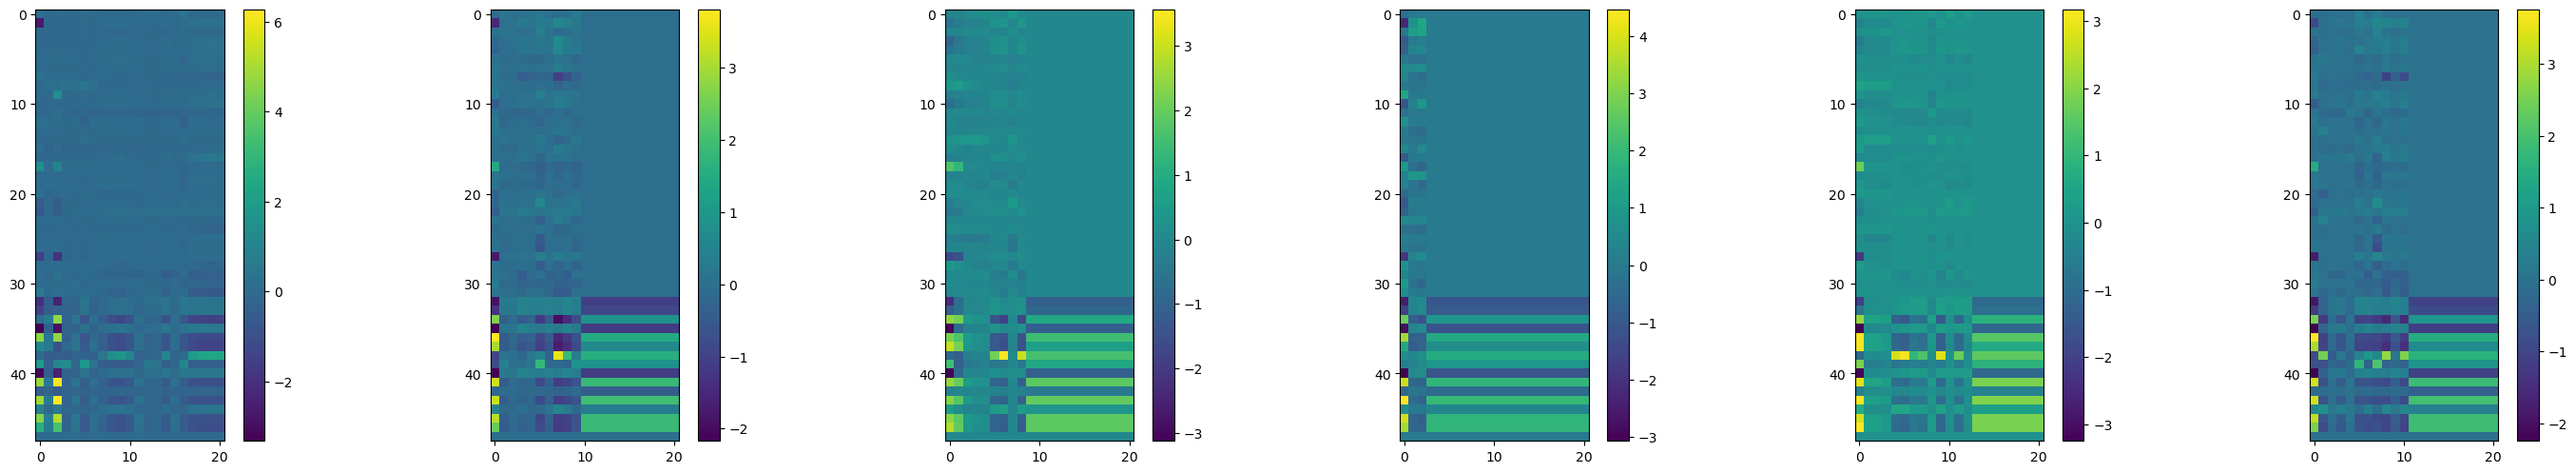

In [57]:
plotM(*concat_GCN_SA[6:12])

# Loss function

In [31]:
y_pred = model(X)
y_true = y 

In [67]:
tf.nn.sigmoid(y_pred[0][10])

<tf.Tensor: shape=(21, 1), dtype=float32, numpy=
array([[9.9995899e-01],
       [8.9316452e-01],
       [8.7852836e-01],
       [7.0904756e-01],
       [1.2696171e-03],
       [5.3690904e-04],
       [5.1229219e-03],
       [2.7311589e-03],
       [7.8313750e-01],
       [4.8703054e-04],
       [1.5987323e-01],
       [1.4040653e-03],
       [1.1473949e-01],
       [5.0000000e-01],
       [5.0000000e-01],
       [5.0000000e-01],
       [5.0000000e-01],
       [5.0000000e-01],
       [5.0000000e-01],
       [5.0000000e-01],
       [5.0000000e-01]], dtype=float32)>

In [68]:
y_true[0][10]

<tf.Tensor: shape=(21, 1), dtype=int64, numpy=
array([[1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])>

In [128]:
dense_clclass, mask_cls, _  = y_pred
y_class, y_metadata = y_true
class_loss  = tf.keras.losses.binary_crossentropy(y_class, dense_clclass, from_logits=True) * mask_cls

reduced_loss = tf.reduce_mean(tf.reduce_sum(class_loss, axis=-1))

In [129]:
class_loss

<tf.Tensor: shape=(64, 25), dtype=float32, numpy=
array([[1.3033892e-02, 1.6305754e-04, 1.6528445e-04, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.3129004e-06, 7.2896878e-06, 7.6203301e-06, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [2.3240897e-04, 8.2204599e+00, 8.4280186e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [1.1351465e-05, 6.7032211e-06, 1.0014297e-05, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [9.0900126e+00, 2.7997307e-06, 2.1766877e-05, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [2.0195195e-05, 2.0179581e-05, 2.1844506e-05, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)>

In [130]:
reduced_loss

<tf.Tensor: shape=(), dtype=float32, numpy=11.784399>

In [51]:
cl_X, cl_hits, is_seed,n_cl = X
cl_ets = cl_X[:,:,1]
cl_ets = cl_X[:,:,1] / tf.reduce_sum(cl_X[:,:,1], axis=-1)[:,tf.newaxis]
class_loss = tf.keras.losses.binary_crossentropy(y_class, dense_clclass, from_logits=True) * mask_cls
weighted_loss = class_loss * cl_ets
reduced_loss = tf.reduce_mean(tf.reduce_sum(weighted_loss, axis=-1))

In [52]:
reduced_loss

<tf.Tensor: shape=(), dtype=float32, numpy=712.43134>

In [139]:
cl_ets

<tf.Tensor: shape=(6, 9), dtype=float32, numpy=
array([[0.99097526, 0.00902472, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.9442082 , 0.01824968, 0.01601619, 0.0136416 , 0.00788432,
        0.        , 0.        , 0.        , 0.        ],
       [0.9814058 , 0.01222331, 0.0063709 , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.96620196, 0.01527102, 0.01035268, 0.00817437, 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.63366574, 0.07908539, 0.0708131 , 0.04544425, 0.04703614,
        0.03674164, 0.03220187, 0.02862877, 0.02638305],
       [0.87168705, 0.03600075, 0.02746342, 0.02085922, 0.02198319,
        0.02200637, 0.        , 0.        , 0.        ]], dtype=float32)>

In [ ]:
 # true energy loss
mask_outsc = tf.cast(true_en == 0., tf.float32)
mask_insc = tf.cast(true_en != 0., tf.float32)
n_outsc = tf.reduce_sum(mask_outsc)
n_insc = tf.reduce_sum(mask_insc)

l2_en = mse_unreduced(true_en, pred_en)
l2_en_log = msle_unreduced(true_en, pred_en)

# separate mean resolution for windows with Caloparticle or not
l2_en_outsc = tf.reduce_sum(l2_en * mask_outsc) / n_outsc
l2_en_insc = tf.reduce_sum(l2_en * mask_insc) / n_insc
l2_en_outsc_log = tf.reduce_sum(l2_en_log * mask_outsc) / n_outsc
l2_en_insc_log = tf.reduce_sum(l2_en_log * mask_insc) / n_insc
    

In [ ]:
reduced_loss = tf.reduce_mean(tf.reduce_sum(class_loss, axis=-

# Test training

In [148]:
from model import *
from plotting import * 

In [70]:
models_path = "/eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v1/"

#rain_steps_per_epoch = 
#eval_steps_per_epoch = 3e5 // batch_size
from collections import namedtuple
# Args = namedtuple('args', [ 'models_path', 'load','nepochs','ntrain','nval','nfeatures',
#                             'n_seed_features','batch_size','lr_decay','lr',
#                             'hidden_dim_input','hidden_dim_coord', 'hidden_dim_id',
#                             'n_layers_input', 'n_layers_id', 'n_layers_coord',
#                            'distance_dim','num_conv','dropout','convlayer',
#                            'nclass_labels', 'opt'])
Args = namedtuple('args', [ 'models_path', 'load','initial_epoch','nepochs','ntrain','nval',
                           'lr_decay','lr', 'batch_size','opt', 'debug'])


args = Args( 
models_path = models_path,
load = False,
initial_epoch = 100,
nepochs = 150,
ntrain = 600000,
nval = 30000,
# nfeatures = 13,
# n_seed_features = 12,
lr_decay = 0.5,
lr = 1e-3,
batch_size = 64,
# n_layers_input = 3,
# n_layers_id = 3,
# n_layers_coord = 3,
# hidden_dim_input = 200,
# hidden_dim_coord = 200,
# hidden_dim_id = 200,
# distance_dim = 200,
# num_conv = 2,
# dropout = 0.2,
# convlayer = 'sgconv',
# nclass_labels=2,
opt='nadam',
debug = False
        )

### Dataset loading

In [134]:
def get_unique_run():
    previous_runs = os.listdir(args.models_path)
    if len(previous_runs) == 0:
        run_number = 1
    else:
        run_number = max([int(s.split('run_')[1]) for s in previous_runs]) + 1
    return run_number


if not os.path.isdir(args.models_path):
    os.makedirs(args.models_path)

name =  'run_{:02}'.format(get_unique_run())

outdir = args.models_path + name

if os.path.isdir(outdir):
    print("Output directory exists: {}".format(outdir), file=sys.stderr)
else:
    os.makedirs(outdir)

print(outdir)

/eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v1/run_40


In [77]:
outdir = '/eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v1/run_40'

In [71]:
data_path_train = {"ele_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v2/training/calo_matched/*.proto",
                  "gamma_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/training/calo_matched/*.proto",
                  #"ele_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v2/training/no_calo_matched/*.proto",
                  #"gamma_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/training/no_calo_matched/*.proto"
                  }
data_path_test = {"ele_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v2/testing/calo_matched/*.proto",
                  "gamma_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/testing/calo_matched/*.proto",
                  #"ele_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v2/testing/no_calo_matched/*.proto",
                  #"gamma_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/testing/no_calo_matched/*.proto"
                  }

In [72]:
features = [ "en_cluster","et_cluster", 
            "cluster_ieta","cluster_iphi","cluster_iz",
            "cluster_deta", "cluster_dphi",
            "cl_r9", "cl_sigmaIetaIeta", "cl_sigmaIetaIphi",
            "cl_sigmaIphiIphi","cl_swissCross",
            "cl_nxtals", "cl_etaWidth","cl_phiWidth"]

In [73]:
# Load a balanced dataset from the list of paths given to the function. Selected only the requestes features from clusters and prepare batches
train_ds = tf_data.load_balanced_dataset_batch(data_path_train, features, args.batch_size, weights={"ele_match":0.5,"gamma_match":0.5})
# the indexes for energy and et are from the features list we requestes
train_ds = tf_data.delta_energy_seed(train_ds, en_index=0, et_index=1)
train_ds = tf_data.training_format(train_ds)


test_ds = tf_data.load_balanced_dataset_batch(data_path_test, features, args.batch_size,weights={"ele_match":0.5,"gamma_match":0.5})
# the indexes for energy and et are from the features list we requestes
test_ds = tf_data.delta_energy_seed(test_ds, en_index=0, et_index=1)
test_ds = tf_data.training_format(test_ds)


# Create training and validation
ds_train = train_ds.prefetch(100).take(args.ntrain).repeat(args.nepochs)
ds_test  = test_ds.prefetch(100).take(args.nval).repeat(args.nepochs)

In [74]:
if args.lr_decay > 0:
        #lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        #    args.lr,
        #    decay_steps=int(args.ntrain//args.batch_size),
        #    decay_rate=args.lr_decay
        #)
        lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
            args.lr,
            decay_steps=int(args.ntrain//args.batch_size),
            decay_rate=args.lr_decay,
            staircase=True
        )
else:
    lr_schedule = args.lr


In [151]:
with strategy.scope():
    opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    # Construction of the model
    model = DeepClusterGN(nconv=3, output_dim_rechits=10, output_dim_nodes=32, layers_input=[64,64,32], layers_coord=[64,64], coord_dim = 3,
                          output_dim_gconv=32, output_dim_sa_class=16, layers_clclass=[64,64,32], dropout=0.2, activation=tf.keras.activations.selu)
    
  
    model.compile(optimizer=args.opt)
#         metrics=[Precision(),Recall(), energy_resolution|_insc,energy_resolution_outsc,
#                      energy_resolution_insc_log,energy_resolution_outsc_log,])
    model.set_metrics()

    for X, y in ds_train:
        ypred = model(X)
        #l = custom_loss(y, ypred)
        break

In [78]:
callbacks = []
tb = tf.keras.callbacks.TensorBoard(
    log_dir=outdir, histogram_freq=2, 
    write_graph=False, 
    write_images=True,
    update_freq='epoch',
    profile_batch=0,
)
tb.set_model(model)
callbacks += [tb]

terminate_cb = tf.keras.callbacks.TerminateOnNaN()
callbacks += [terminate_cb]

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=outdir + "/weights.{epoch:02d}-{val_loss:.6f}.hdf5",
    save_weights_only=True,
    verbose=1
)
cp_callback.set_model(model)
callbacks += [cp_callback]



In [15]:
model.summary()

Model: "deep_cluster_gn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
graph_building (GraphBuildin multiple                  11023     
_________________________________________________________________
gh_conv_i_1 (GHConvI)        multiple                  2080      
_________________________________________________________________
concatenate_1 (Concatenate)  multiple                  0         
_________________________________________________________________
self_attention (SelfAttentio multiple                  2336      
_________________________________________________________________
sequential_2 (Sequential)    (64, 20, 1)               7361      
_________________________________________________________________
dropout_5 (Dropout)          multiple                  0         
_________________________________________________________________
dropout_6 (Dropout)          multiple              

In [ ]:
if args.load:
    #ensure model input size is known
    for X, y in ds_train:
        model(X)
        break

    model.load_weights(args.load)
    
if args.nepochs > 0:
    ret = model.fit(ds_train,
        validation_data=ds_test, 
        epochs=args.nepochs,
        steps_per_epoch=args.ntrain//args.batch_size, 
        validation_steps=args.nval//args.batch_size,
        verbose=True,
        callbacks = callbacks,
        initial_epoch = args.initial_epoch
    )

Epoch 101/150
9373/9375 [============================>.] - ETA: 0s - loss: 1.5534 - loss_simple: 1.4612 - loss_etweighted: 0.0468
Epoch 00101: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v1/run_40/weights.101-1.440213.hdf5
9375/9375 [==============================] - 206s 22ms/step - loss: 1.5533 - loss_simple: 1.4612 - loss_etweighted: 0.0468 - val_loss: 1.4402 - val_loss_simple: 1.3546 - val_loss_etweighted: 0.0416
Epoch 102/150
9375/9375 [==============================] - ETA: 0s - loss: 1.5518 - loss_simple: 1.4602 - loss_etweighted: 0.0462
Epoch 00102: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v1/run_40/weights.102-1.465004.hdf5
9375/9375 [==============================] - 203s 22ms/step - loss: 1.5518 - loss_simple: 1.4602 - loss_etweighted: 0.0462 - val_loss: 1.4650 - val_loss_simple: 1.3769 - val_loss_etweighted: 0.0419
Epoch 103/150
9374/9375 [===================

9374/9375 [============================>.] - ETA: 0s - loss: 1.5451 - loss_simple: 1.4536 - loss_etweighted: 0.0458
Epoch 00118: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v1/run_40/weights.118-1.469003.hdf5
9375/9375 [==============================] - 203s 22ms/step - loss: 1.5451 - loss_simple: 1.4536 - loss_etweighted: 0.0458 - val_loss: 1.4690 - val_loss_simple: 1.3810 - val_loss_etweighted: 0.0429
Epoch 119/150
9375/9375 [==============================] - ETA: 0s - loss: 1.5429 - loss_simple: 1.4517 - loss_etweighted: 0.0460
Epoch 00119: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v1/run_40/weights.119-1.443237.hdf5
9375/9375 [==============================] - 203s 22ms/step - loss: 1.5429 - loss_simple: 1.4517 - loss_etweighted: 0.0460 - val_loss: 1.4432 - val_loss_simple: 1.3566 - val_loss_etweighted: 0.0415
Epoch 120/150
9374/9375 [============================>.] -

9374/9375 [============================>.] - ETA: 0s - loss: 1.5376 - loss_simple: 1.4469 - loss_etweighted: 0.0456
Epoch 00135: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v1/run_40/weights.135-1.461149.hdf5
9375/9375 [==============================] - 203s 22ms/step - loss: 1.5376 - loss_simple: 1.4469 - loss_etweighted: 0.0456 - val_loss: 1.4611 - val_loss_simple: 1.3724 - val_loss_etweighted: 0.0421
Epoch 136/150
9373/9375 [============================>.] - ETA: 0s - loss: 1.5481 - loss_simple: 1.4574 - loss_etweighted: 0.0457
Epoch 00136: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v1/run_40/weights.136-1.451633.hdf5
9375/9375 [==============================] - 204s 22ms/step - loss: 1.5481 - loss_simple: 1.4574 - loss_etweighted: 0.0457 - val_loss: 1.4516 - val_loss_simple: 1.3658 - val_loss_etweighted: 0.0421
Epoch 137/150
9374/9375 [============================>.] -

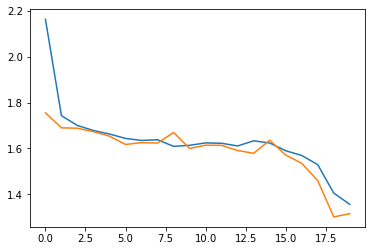

In [40]:
plt.plot(ret.history["loss"])
plt.plot(ret.history["val_loss"])
#plt.ylim(0.2,2) 

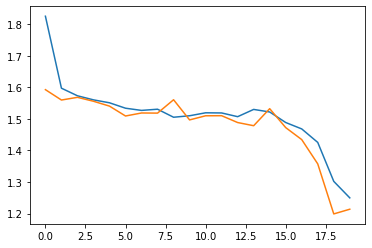

In [41]:
plt.plot(ret.history["loss_simple"])
plt.plot(ret.history["val_loss_simple"])
#plt.ylim(0.2,2) 

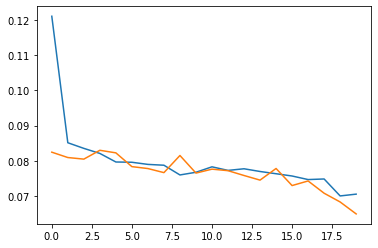

In [42]:
plt.plot(ret.history["loss_etweighted"])
plt.plot(ret.history["val_loss_etweighted"])
#plt.ylim(0.2,2) 

In [61]:
model.layers

In [64]:
a = model.layers[0]

In [36]:
model.layers[0].weights

[<tf.Variable 'Q_sa:0' shape=(32, 32) dtype=float32, numpy=
 array([[ 0.01409095, -0.03945024,  0.03273902, ...,  0.00563247,
         -0.09460284, -0.08979334],
        [ 0.00932704, -0.01806019,  0.00853294, ...,  0.03431287,
         -0.07305345, -0.00853185],
        [-0.01922124,  0.09511406,  0.08944473, ...,  0.01599297,
          0.09474896,  0.11926842],
        ...,
        [ 0.04462522, -0.07311994, -0.0176611 , ...,  0.03971514,
          0.07315613, -0.05048703],
        [-0.00780735, -0.05002181,  0.04826789, ...,  0.06284268,
         -0.04511618, -0.1076005 ],
        [ 0.10039943,  0.00942462,  0.04088863, ..., -0.05311667,
         -0.02586613, -0.04978501]], dtype=float32)>,
 <tf.Variable 'K_sa:0' shape=(32, 32) dtype=float32, numpy=
 array([[ 1.18576027e-01, -5.87328896e-02, -6.56343345e-03, ...,
         -4.06912602e-02,  5.08538745e-02,  4.10512388e-02],
        [-3.58481146e-02, -2.17429232e-02, -3.10256258e-02, ...,
         -6.12121366e-05, -1.88398280e-03,  7.

In [69]:
model.load_weights("/eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v1/run_40/weights.82-1.462194.hdf5")

In [79]:
with open(outdir + "/args.txt",'w') as config:
    config.write(str(args))
    
model.save(outdir+"/model")
    

# Debug model



In [ ]:
#OLd model
